In [40]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
from collections import defaultdict
from collections import Counter
from PIL import Image
from tensorflow.keras.callbacks import ReduceLROnPlateau



In [7]:
path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")
print("Path to dataset:", path)

Path to dataset: C:\Users\jli20\.cache\kagglehub\datasets\mahmoudreda55\satellite-image-classification\versions\1


In [8]:
def convert_all_to_rgb(directory):
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                with Image.open(file_path) as img:
                    if img.mode != 'RGB':
                        rgb_img = img.convert('RGB')
                        rgb_img.save(file_path)
            except Exception as e:
                print(f"Failed on {file_path}: {e}")

In [9]:
data_path = os.path.join(path, 'data')
subfolders = os.listdir(data_path)
print("Class folders:", subfolders)
convert_all_to_rgb(data_path)

Class folders: ['cloudy', 'desert', 'green_area', 'water']


In [10]:
img_size = (224, 224)
batch_size = 32

dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    image_size=img_size,
    batch_size=batch_size,
    color_mode='rgb'
)

unbatched_ds = dataset.unbatch()

class_names = dataset.class_names
print("Class names:", class_names)

Found 5631 files belonging to 4 classes.
Class names: ['cloudy', 'desert', 'green_area', 'water']


In [11]:
"""
{
  'cloudy': [(img1, lbl1), (img2, lbl2)]
  'desert': [.......]
  ......
}
"""

class_datasets = defaultdict(list)

for image, label in unbatched_ds:
    class_idx = int(label.numpy())
    class_name = class_names[class_idx]
    class_datasets[class_name].append((image, label))

In [12]:
def make_class_dataset(data_tuples, batch_size):
    imgs, labels = zip(*data_tuples)
    ds = tf.data.Dataset.from_tensor_slices((list(imgs), list(labels)))
    return ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
cloudy_ds = make_class_dataset(class_datasets["cloudy"], batch_size)
desert_ds = make_class_dataset(class_datasets["desert"], batch_size)
green_ds  = make_class_dataset(class_datasets["green_area"], batch_size)
water_ds  = make_class_dataset(class_datasets["water"], batch_size)

In [14]:
def count_images(dataset):
    return sum(1 for _ in dataset.unbatch())

In [15]:
print("Cloudy images:", count_images(cloudy_ds))
print("Desert images:", count_images(desert_ds))
print("Green images:", count_images(green_ds))
print("Water images:", count_images(water_ds))

Cloudy images: 1500
Desert images: 1131
Green images: 1500
Water images: 1500


In [16]:
for image, label in cloudy_ds.take(1):
    print("Min:", tf.reduce_min(image).numpy())
    print("Max:", tf.reduce_max(image).numpy())
    print("Mean:", tf.reduce_mean(image).numpy())

Min: 24.56112
Max: 249.7143
Mean: 147.54503


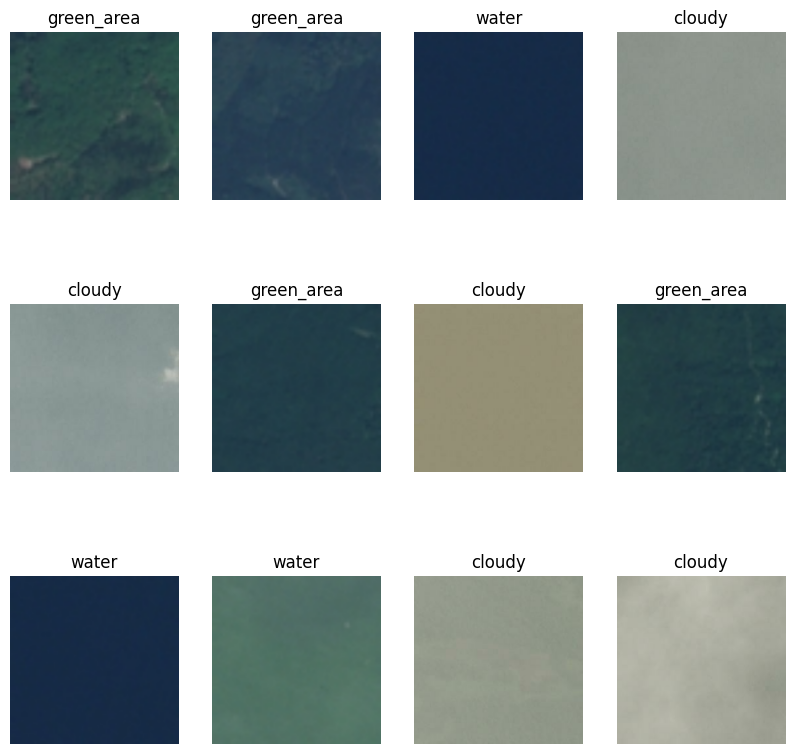

In [17]:
class_names = dataset.class_names

number_of_images = 12

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):  # One batch
    for i in range(number_of_images):
        ax = plt.subplot(number_of_images//4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,      # 20% for validation
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Train images:", tf.data.experimental.cardinality(train_ds).numpy() * 16)
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Val images:", tf.data.experimental.cardinality(val_ds).numpy() * 16)



Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.
Train batches: 141
Train images: 2256
Val batches: 36
Val images: 576


In [19]:
def count_class_number(dataset):
    train_counter = Counter()

    for _, label in dataset.unbatch():
        train_counter[int(label.numpy())] += 1

    # Map class indices to names
    class_names = dataset.class_names
    train_distribution = {class_names[i]: count for i, count in train_counter.items()}

    print("Training set class distribution:")
    for k, v in train_distribution.items():
        print(f"{k}: {v}")

In [20]:
shuffled_cloudy = (
    cloudy_ds
    .unbatch()
    .shuffle(buffer_size=2000)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

shuffled_green = (
    green_ds
    .unbatch()
    .shuffle(buffer_size=2000)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

shuffled_desert = (
    desert_ds
    .unbatch()
    .shuffle(buffer_size=2000)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

shuffled_water = (
    water_ds
    .unbatch()
    .shuffle(buffer_size=2000)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

In [21]:
print(type(water_ds))
print(type(shuffled_water))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


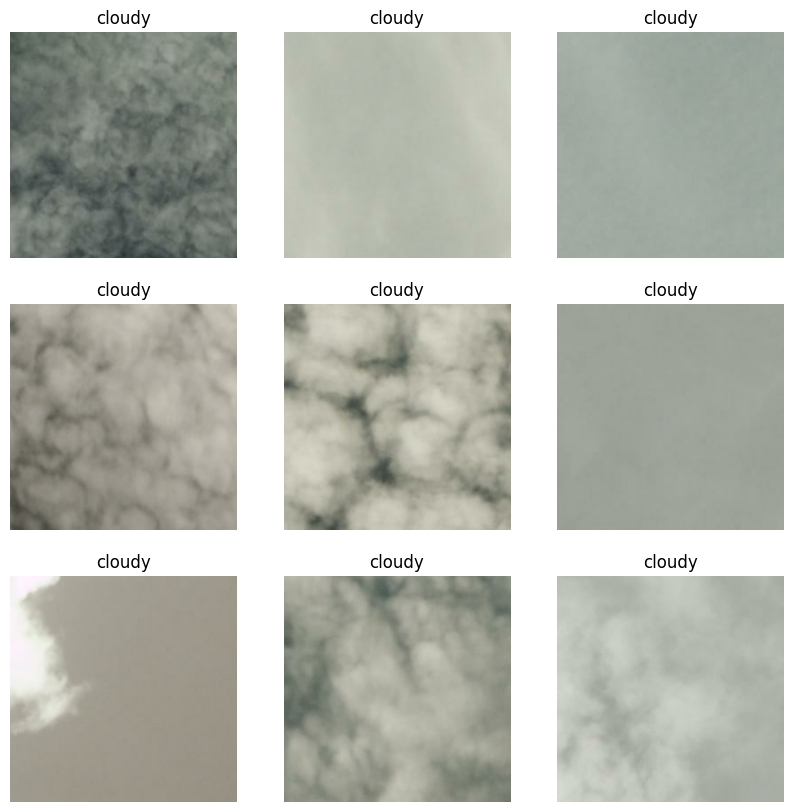

In [22]:
number_of_images = 9

plt.figure(figsize=(10, 10))
for images, labels in shuffled_cloudy.take(1):  # One batch
    for i in range(number_of_images):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i].numpy())])
        plt.axis("off")

In [23]:
pre_split_cloudy = list(shuffled_cloudy.unbatch())
pre_split_green = list(shuffled_green.unbatch())
pre_split_water = list(shuffled_water.unbatch())
pre_split_desert = list(shuffled_desert.unbatch())

In [24]:
def relabel(data, new_label):
    return [(img, tf.constant(new_label)) for (img, _) in data]

cloudy = relabel(pre_split_cloudy, 0)
desert = relabel(pre_split_cloudy, 1)
green  = relabel(pre_split_green, 2)
water  = relabel(pre_split_water, 3)

In [25]:
def dataset_split(data, train_ratio):
    i = int(len(data) * train_ratio)
    return data[:i], data[i:]

In [26]:
cloudy_train, cloudy_val = dataset_split(pre_split_cloudy, 0.8)
green_train, green_val = dataset_split(pre_split_green, 0.8)
water_train, water_val = dataset_split(pre_split_water, 0.8)
desert_train, desert_val = dataset_split(pre_split_desert, 0.8)


In [27]:
train_data = cloudy_train + desert_train + green_train + water_train
val_data   = cloudy_val + desert_val + green_val + water_val

In [28]:
def to_tf_dataset(data, batch_size):
    imgs, labels = zip(*data)
    ds = tf.data.Dataset.from_tensor_slices((list(imgs), list(labels)))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [29]:
batch_size = 32
train_ds = to_tf_dataset(train_data, batch_size)
val_ds   = to_tf_dataset(val_data, batch_size)

In [30]:
train_ds = train_ds.shuffle(buffer_size=10000)
val_ds = val_ds.shuffle(buffer_size=5000)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    # tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='softmax')
])

c:\Users\jli20\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [41]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,        # reduce by half
    patience=3,        # after 3 epochs of no improvement
    verbose=1,
    min_lr=1e-6
)

In [33]:
label_counts = Counter()

for _, label in train_ds.unbatch():
    label_counts[int(label.numpy())] += 1

print("Training label distribution:")
for class_index, count in label_counts.items():
    print(f"Class {class_index}: {count} samples")

Training label distribution:
Class 3: 1200 samples
Class 2: 1200 samples
Class 1: 904 samples
Class 0: 1200 samples


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[lr_scheduler]
)

Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 110s 735ms/step - accuracy: 0.5745 - loss: 0.7092 - val_accuracy: 0.6291 - val_loss: 0.5981 - learning_rate: 0.0010
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 97s 661ms/step - accuracy: 0.6468 - loss: 0.5451 - val_accuracy: 0.7542 - val_loss: 0.4857 - learning_rate: 0.0010
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 96s 665ms/step - accuracy: 0.7242 - loss: 0.5419 - val_accuracy: 0.6664 - val_loss: 0.5086 - learning_rate: 0.0010
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 101s 715ms/step - accuracy: 0.6121 - loss: 0.5747 - val_accuracy: 0.5031 - val_loss: 0.8601 - learning_rate: 0.0010
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.5579 - loss: 0.7059
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
141/141 ━━━━━━━━━━━━━━━━━━━━ 102s 722ms/step - accuracy: 0.5581 - loss: 0.7055 - val_accuracy: 0.7169 - val_loss: 0.4898 - learning_rate: 0.0010
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 103s 727ms/step - accuracy: 0

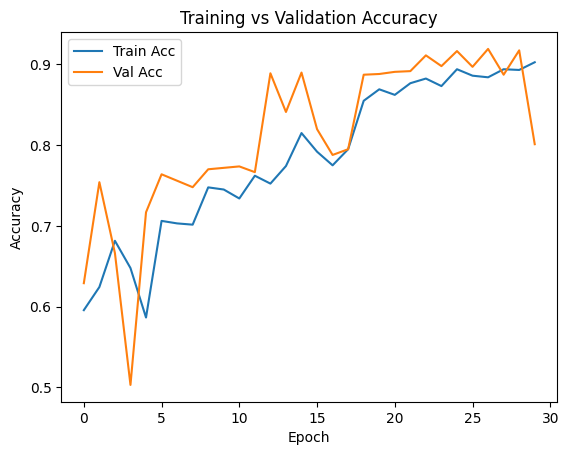

In [43]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

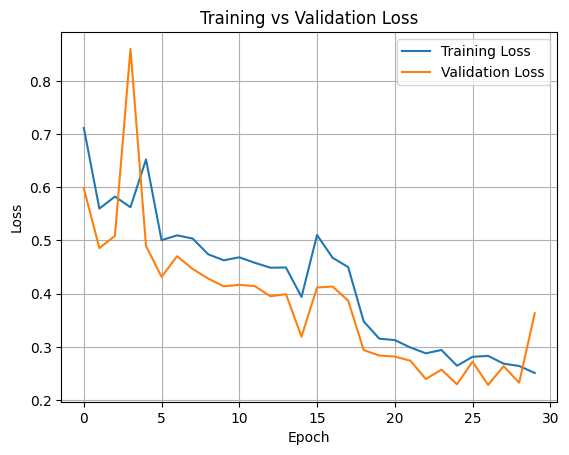

In [44]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(tf.__version__)

2.19.0
